In [1]:
import mph
import matplotlib.pyplot as plt

import pyro
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO,TraceGraph_ELBO, MCMC, NUTS, HMC

import torch
from torch.distributions import constraints
import pyro.poutine as poutine
from pyro.poutine.runtime import effectful

import matplotlib.pyplot as plt
import seaborn as sns
import time 

from scipy import stats
import graphviz
from tqdm import tqdm


import yaml


In [2]:

def mobilityFuncModel(E_dist, rho_dist, eta_dist, freq, E_theo=10e10, rho_theo=8976, eta_theo=0.007):
    """
    Calculates the mobility value based on the Young's modulus(E) and the frequency
    Input: 
        E   : Young's modulus
        eta : loss factor
    Output: 
        Y   : Mobility value
    """
    beam = {"length": 0.301,
        "width": 0.026,
        "thickness": 0.003,
        
        "E": 10e10,
        
        "mass": 0.1877,
        
        }
    beam["massPerUnit"] = beam["mass"] / beam["length"]
    beam["volume"] = beam["length"] * beam["width"] * beam["thickness"]
    beam["I"] = beam["width"]*beam["thickness"]**3/12

    E = E_dist
    rho = rho_dist
    eta = eta_dist
    l = beam["length"]/2

    # calculating the bending wave number
    w = 2*torch.pi*freq # Angular frequency
    B = E*beam["I"] #
    complex_B = E*(1+1j*eta)*beam["I"]
    massPerUnit = rho*beam["thickness"]*beam["width"]
    cb = torch.sqrt(w)*(B/massPerUnit)**(1/4) # bending wave velocity
    
    kl = w/(cb)*l # bending wave number
    complex_kl = kl*(1-1j*eta/4)
    N_l = torch.cos(complex_kl)*torch.cosh(complex_kl) + 1
    D_l = torch.cos(complex_kl)*torch.sinh(complex_kl) + torch.sin(complex_kl)*torch.cosh(complex_kl)

    Y = -(1j*l)/ (2*complex_kl*torch.sqrt(complex_B *massPerUnit)) * N_l/D_l
    return abs(Y)

def solveComsol(modelComsol, E, rho, eta):#, freq=10):
    # Update parameters
    modelComsol.parameter('Youngs', str(E)+' [Pa]')
    modelComsol.parameter('density', str(rho)+' [kg/m^3]')
    modelComsol.parameter('damping', str(eta))

    # Solving comsol FEM
    print(modelComsol.parameters())
    modelComsol.solve("Study 3")
    comsolResults = torch.tensor(abs(modelComsol.evaluate("comp1.point1")))

    return comsolResults

In [3]:

client = mph.start()
modelComsol = client.load("../comsol/beam.mph")


{'Youngs': '100000000000.0 [Pa]', 'density': '830 [kg/m^3]', 'F0': '5 [N]', 'damping': '0.05'}
{'Youngs': '90000000000.0 [Pa]', 'density': '800 [kg/m^3]', 'F0': '5 [N]', 'damping': '0.07'}
{'Youngs': '90000000000.0 [Pa]', 'density': '800 [kg/m^3]', 'F0': '5 [N]', 'damping': '0.005'}


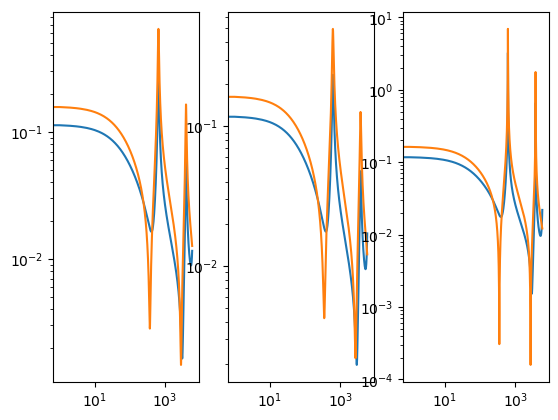

In [4]:
E0 = 10e10
rho0 = 830
eta0 = 0.05
freq = [117.5,  118. ,  118.5,  119. ,  119.5,  121. ,  121.5,  122. , 122.5,  123. ,  644.5,  645. ,  645.5,  646. ,  646.5,  647. ,   647.5,  648. ,  648.5,  649. ,  649.5,  650. ,  650.5,  651. ,  1599.5, 1600. , 1600.5, 1601. , 1601.5, 1602. , 1602.5, 1603.]
freq = np.arange(50, 3000.5, 0.5)
comsol0 = solveComsol(modelComsol, E0, rho0, eta0)
analytical0 = mobilityFuncModel(torch.tensor(E0), torch.tensor(rho0), torch.tensor(eta0), torch.tensor(freq))

E1 = 9e10
rho1 = 800
eta1 = 0.07
comsol1 = solveComsol(modelComsol, E1, rho1, eta1)
analytical1 = mobilityFuncModel(torch.tensor(E1), torch.tensor(rho1), torch.tensor(eta1), torch.tensor(freq))

E2 = 9e10
rho2 = 800
eta2 = 0.005
comsol2 = solveComsol(modelComsol, E2, rho2, eta2)
analytical2 = mobilityFuncModel(torch.tensor(E2), torch.tensor(rho2), torch.tensor(eta2), torch.tensor(freq))


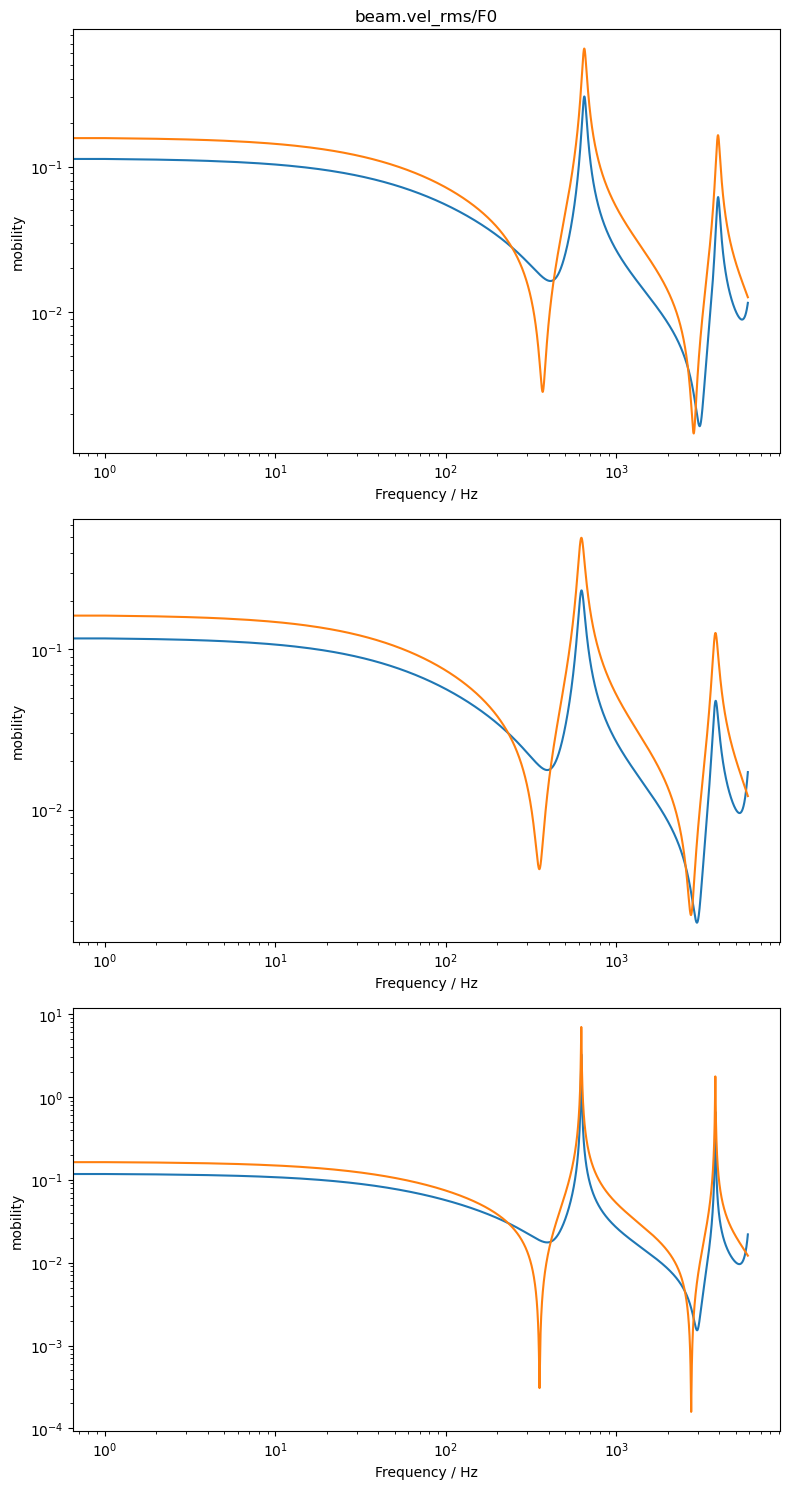

In [15]:
fig, ax = plt.subplots(figsize=(8,15), nrows=3)
ax[0].set_title("beam.vel_rms/F0")
ax[0].plot(comsol0)
ax[0].plot(analytical0)
ax[1].plot(comsol1)
ax[1].plot(analytical1)
ax[2].plot(comsol2)
ax[2].plot(analytical2)
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[2].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[2].set_yscale("log")
ax[0].set_xlabel("Frequency / Hz")
ax[1].set_xlabel("Frequency / Hz")
ax[2].set_xlabel("Frequency / Hz")
ax[0].set_ylabel("mobility")
ax[1].set_ylabel("mobility")
ax[2].set_ylabel("mobility")
fig.tight_layout()
plt.savefig("comsolVSanalytical.png")

In [16]:

client = mph.start()
modelComsol = client.load("../comsol/beam.mph")

In [17]:
E0 = 10e10
rho0 = 830
eta0 = 0.05
freq = [117.5,  118. ,  118.5,  119. ,  119.5,  121. ,  121.5,  122. , 122.5,  123. ,  644.5,  645. ,  645.5,  646. ,  646.5,  647. ,   647.5,  648. ,  648.5,  649. ,  649.5,  650. ,  650.5,  651. ,  1599.5, 1600. , 1600.5, 1601. , 1601.5, 1602. , 1602.5, 1603.]
freq = np.arange(50, 3000.5, 0.5)
comsol0 = solveComsol(modelComsol, E0, rho0, eta0)
analytical0 = mobilityFuncModel(torch.tensor(E0), torch.tensor(rho0), torch.tensor(eta0), torch.tensor(freq))

E1 = 9e10
rho1 = 800
eta1 = 0.07
comsol1 = solveComsol(modelComsol, E1, rho1, eta1)
analytical1 = mobilityFuncModel(torch.tensor(E1), torch.tensor(rho1), torch.tensor(eta1), torch.tensor(freq))

E2 = 9e10
rho2 = 800
eta2 = 0.005
comsol2 = solveComsol(modelComsol, E2, rho2, eta2)
analytical2 = mobilityFuncModel(torch.tensor(E2), torch.tensor(rho2), torch.tensor(eta2), torch.tensor(freq))


{'Youngs': '100000000000.0 [Pa]', 'density': '830 [kg/m^3]', 'F0': '5 [N]', 'damping': '0.05'}
{'Youngs': '90000000000.0 [Pa]', 'density': '800 [kg/m^3]', 'F0': '5 [N]', 'damping': '0.07'}
{'Youngs': '90000000000.0 [Pa]', 'density': '800 [kg/m^3]', 'F0': '5 [N]', 'damping': '0.005'}


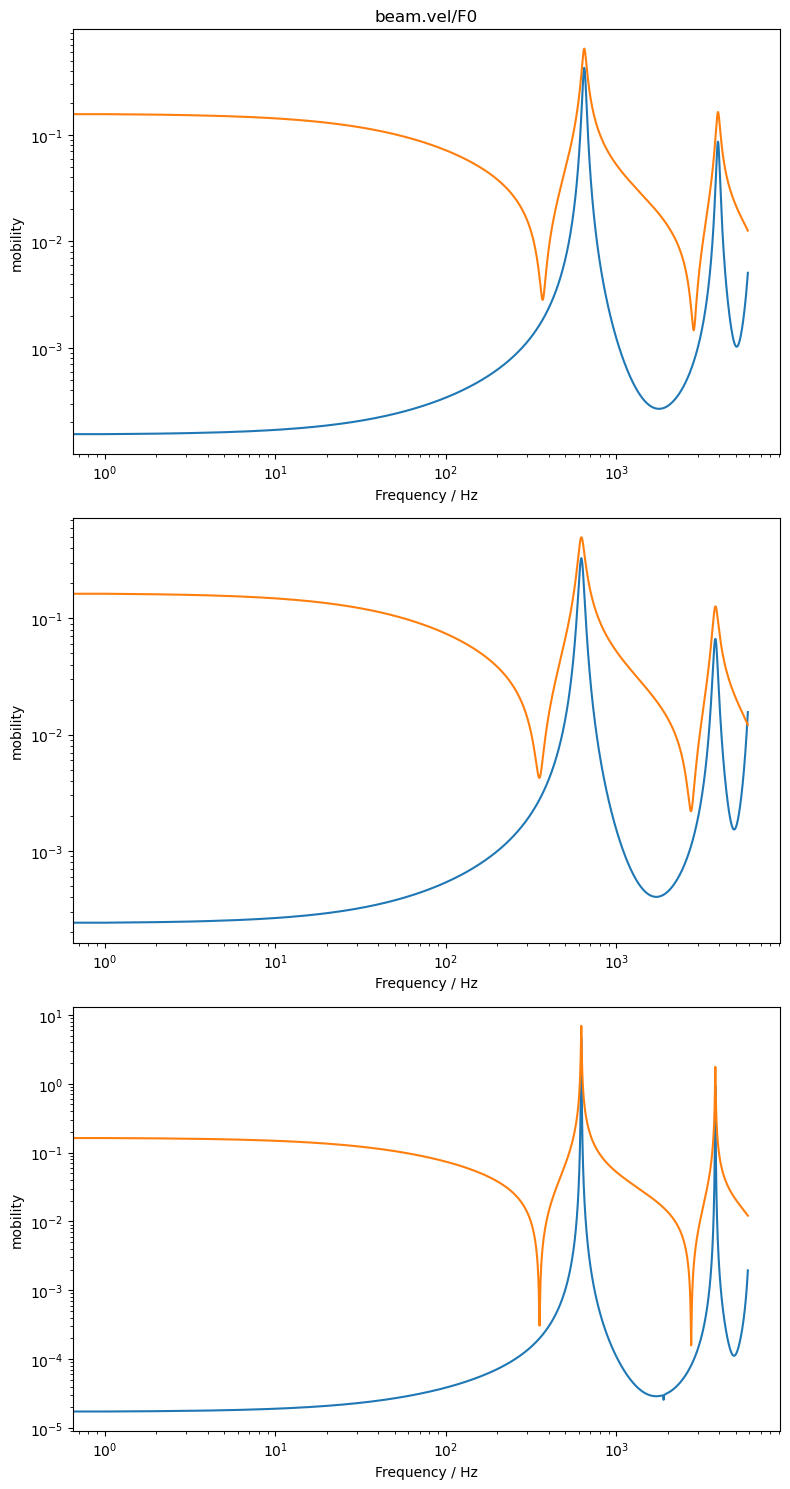

In [18]:
fig, ax = plt.subplots(figsize=(8,15), nrows=3)
ax[0].set_title("beam.vel/F0")
ax[0].plot(comsol0)
ax[0].plot(analytical0)
ax[1].plot(comsol1)
ax[1].plot(analytical1)
ax[2].plot(comsol2)
ax[2].plot(analytical2)
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[2].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[2].set_yscale("log")
ax[0].set_xlabel("Frequency / Hz")
ax[1].set_xlabel("Frequency / Hz")
ax[2].set_xlabel("Frequency / Hz")
ax[0].set_ylabel("mobility")
ax[1].set_ylabel("mobility")
ax[2].set_ylabel("mobility")
fig.tight_layout()
plt.savefig("comsolVSanalytical.png")